In [1]:
import numpy as np
import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
import pickle
from sbi.analysis import pairplot

from Chempy.parameter import ModelParameters
import sbi.utils as utils

/Users/bguenes/miniconda3/envs/master_chempy_multi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ------ Load & prepare the data ------

# --- Load in training data ---
path_training = '../ChempyMulti/tutorial_data/TNG_Training_Data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = '../ChempyMulti/tutorial_data/TNG_Test_Data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)


# --- Normalize the data ---
x_mean, x_std = train_x.mean(axis=0), train_x.std(axis=0)
y_mean, y_std = train_y.mean(axis=0), train_y.std(axis=0)


def normalize_data(x, y, x_mean=x_mean, x_std=x_std, y_mean=y_mean, y_std=y_std):
    x = (x - x_mean) / x_std
    y = (y - y_mean) / y_std

    return x, y


train_x, train_y = normalize_data(train_x, train_y)
val_x, val_y     = normalize_data(val_x, val_y)


# add time squared as parameter
def add_time_squared(x):
    time_squared = np.array([x.T[-1]**2]).T
    if len(x.shape) == 1:
        return np.concatenate((x, time_squared))
    elif len(x.shape) == 2:
        return np.concatenate((x, time_squared), axis=1)


train_x = add_time_squared(train_x)
val_x = add_time_squared(val_x)




In [3]:

if torch.backends.mps.is_available():
    print("using mps")
    device = torch.device("mps")

else:
    print("using cpu")
    device = torch.device("cpu")


class Model_Torch(torch.nn.Module):
    def __init__(self):
        super(Model_Torch, self).__init__()
        self.l1 = torch.nn.Linear(train_x.shape[1], 100)
        self.l2 = torch.nn.Linear(100, 40)
        self.l3 = torch.nn.Linear(40, train_y.shape[1])

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x


model = Model_Torch()
model.load_state_dict(torch.load('data/pytorch_state_dict.pt'))
model.eval()

model.to(device)


using mps


Model_Torch(
  (l1): Linear(in_features=7, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=40, bias=True)
  (l3): Linear(in_features=40, out_features=9, bias=True)
)

In [4]:

x = np.load('data/tutorial_weights.npz')

w0 = x['w0']
w1 = x['w1']
b0 = x['b0']
b1 = x['b1']
in_mean = x['in_mean']
in_std = x['in_std']
out_mean = x['out_mean']
out_std = x['out_std']
activation = x['activation']
neurons = x['neurons']


def add_time_squared(x):
    time_squared = np.array([x.T[-1] ** 2]).T
    if len(x.shape) == 1:
        return np.concatenate((x, time_squared))
    elif len(x.shape) == 2:
        return np.concatenate((x, time_squared), axis=1)


def simulator_NN_torch(in_par):
    in_par = (in_par - in_mean) / in_std
    in_par = add_time_squared(in_par)

    in_par = torch.tensor(in_par, dtype=torch.float32).to(device)

    out = model(in_par)

    return out.detach().cpu().numpy() * out_std + out_mean


In [5]:

# ----- Set-up priors -----
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

combined_priors = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

# ----- Load the posterior -----
with open("data/posterior_SNPE_torch.pickle", "rb") as f:
    posterior = pickle.load(f)



Drawing 10000 posterior samples: 10078it [00:01, 6224.08it/s]                          


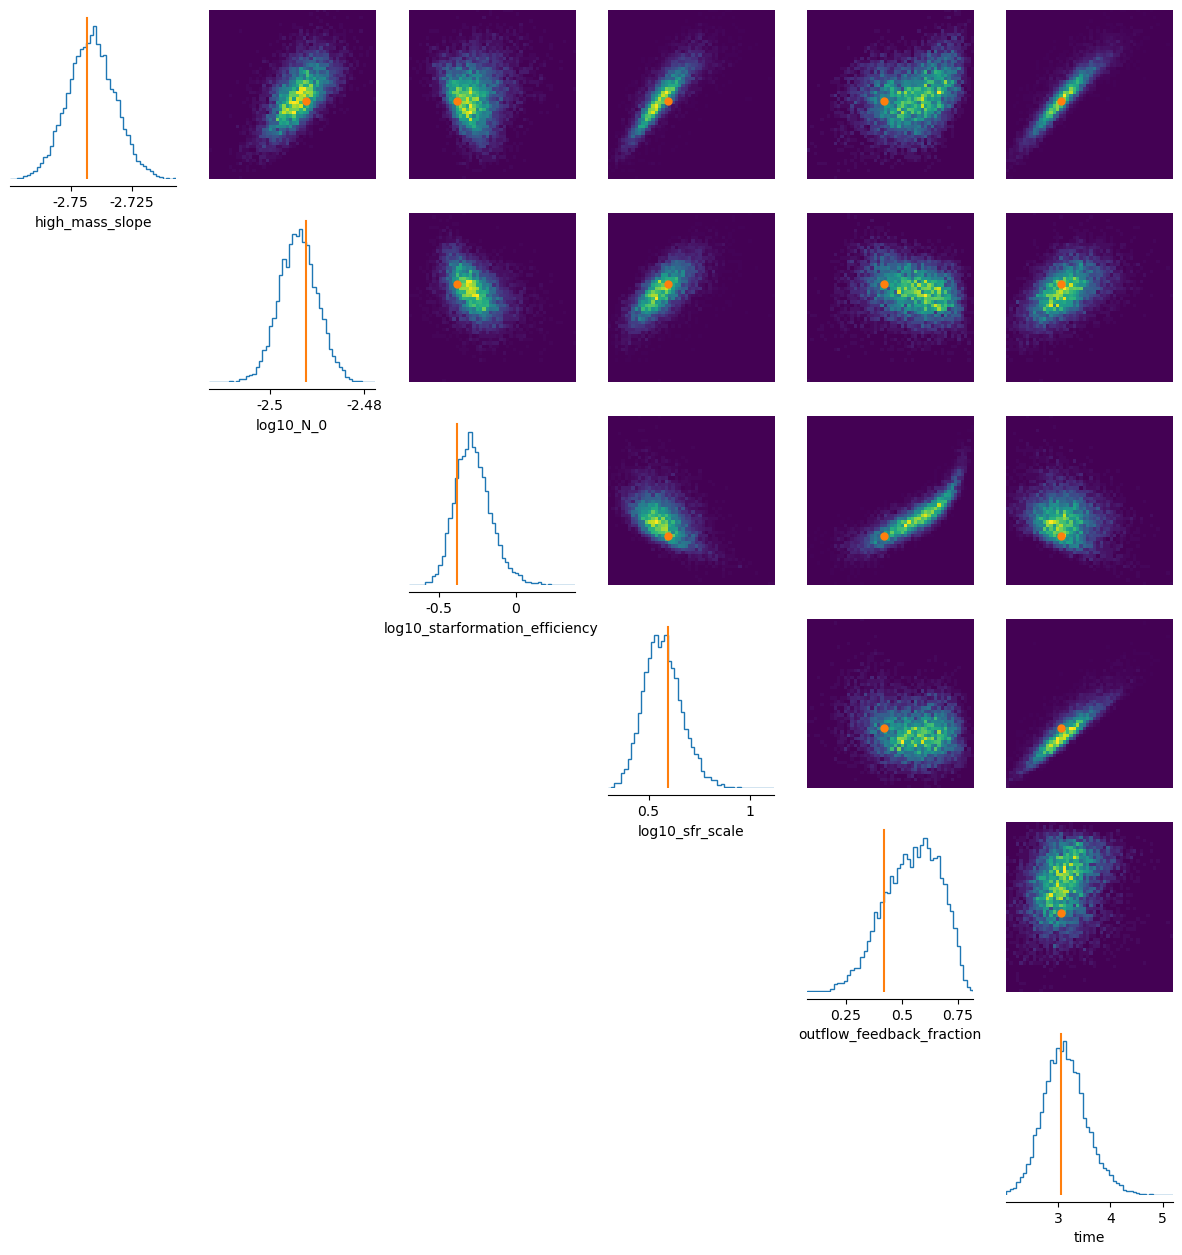

In [6]:

# ----- Evaluate the posterior -----
# ----- Simulate data -----
prior = combined_priors.sample((1,))
simulated_data = simulator_NN_torch(prior)

posterior_samples = posterior.sample((10000,), x=simulated_data)
_ = pairplot(posterior_samples, figsize=(15, 15), points=prior, labels=labels)


Drawing 10000 posterior samples: 10176it [00:18, 554.50it/s]                          


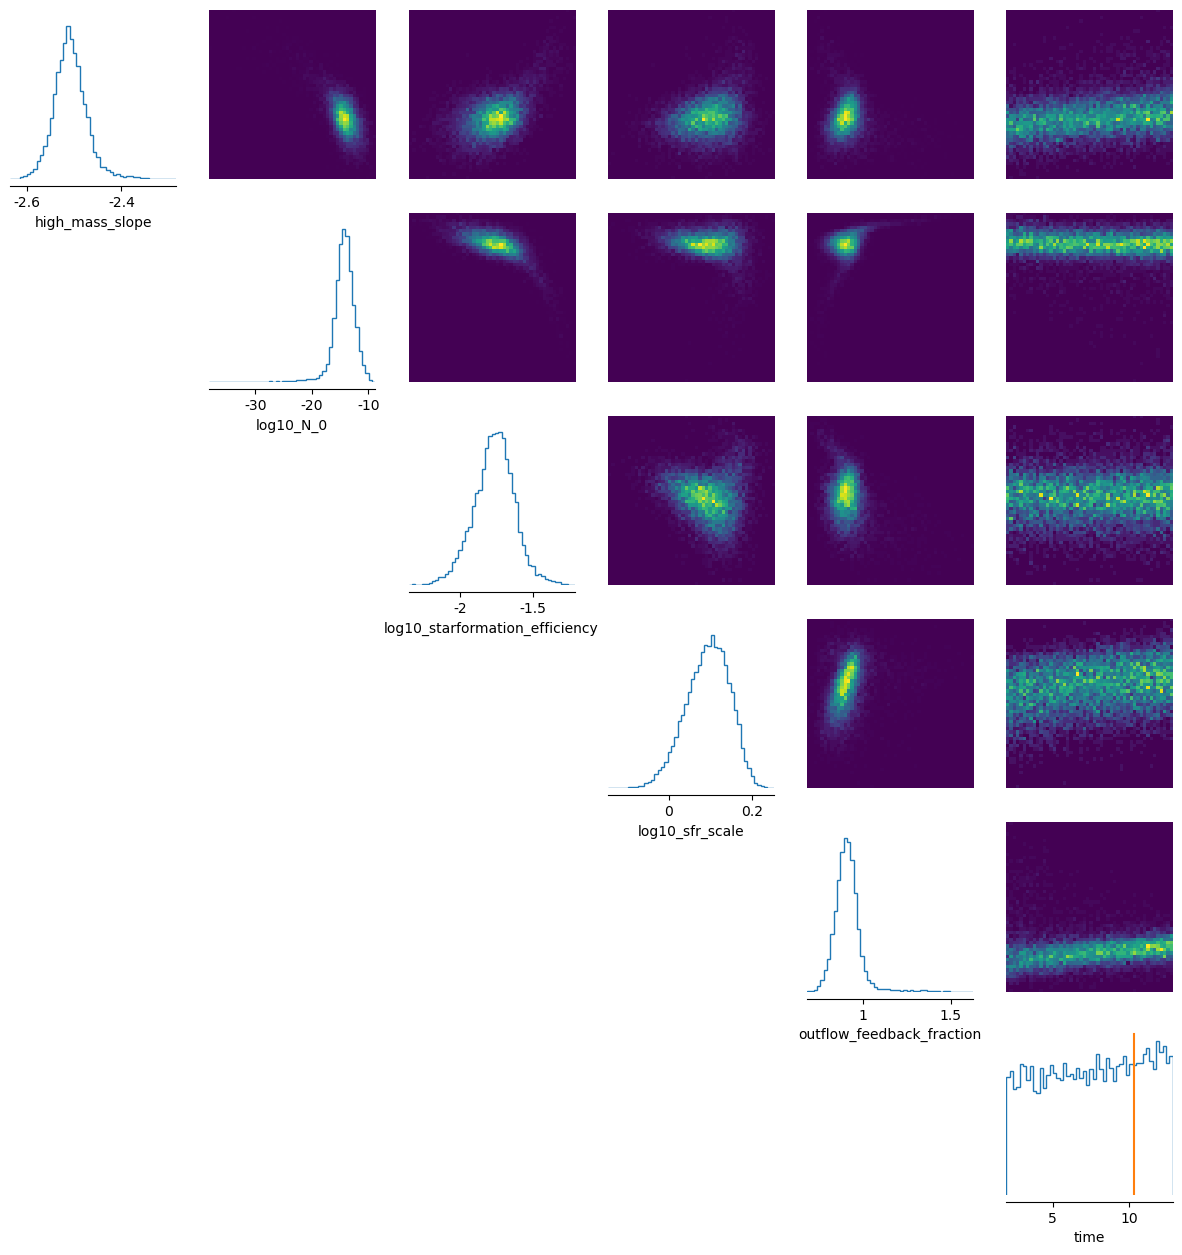

In [7]:

# ----- Evaluate the posterior -----
# evaluation data
index = 100
x = val_x[index][:-1]*x_std + x_mean
y = val_y[index]

posterior_samples = posterior.sample((10000,), x=y)
_ = pairplot(posterior_samples, figsize=(15, 15), points=x, labels=labels)


In [14]:
from Chempy.cem_function import single_timestep_chempy

with open("data/posterior_SNPE_chempy.pickle", "rb") as f:
    posterior = pickle.load(f)  
    
# ----- Evaluate the posterior -----
a = ModelParameters()
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

combined_priors = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

def simulator_chempy(sample):
    out = single_timestep_chempy((sample.numpy().tolist(),a))
    return out[0]

prior = combined_priors.sample()
simulated_data = simulator_chempy(prior)


Drawing 10000 posterior samples: 10065it [00:01, 7401.64it/s]                          


tensor([-2.2622, -2.6705, -0.4714,  0.6629,  0.5676,  5.9058])


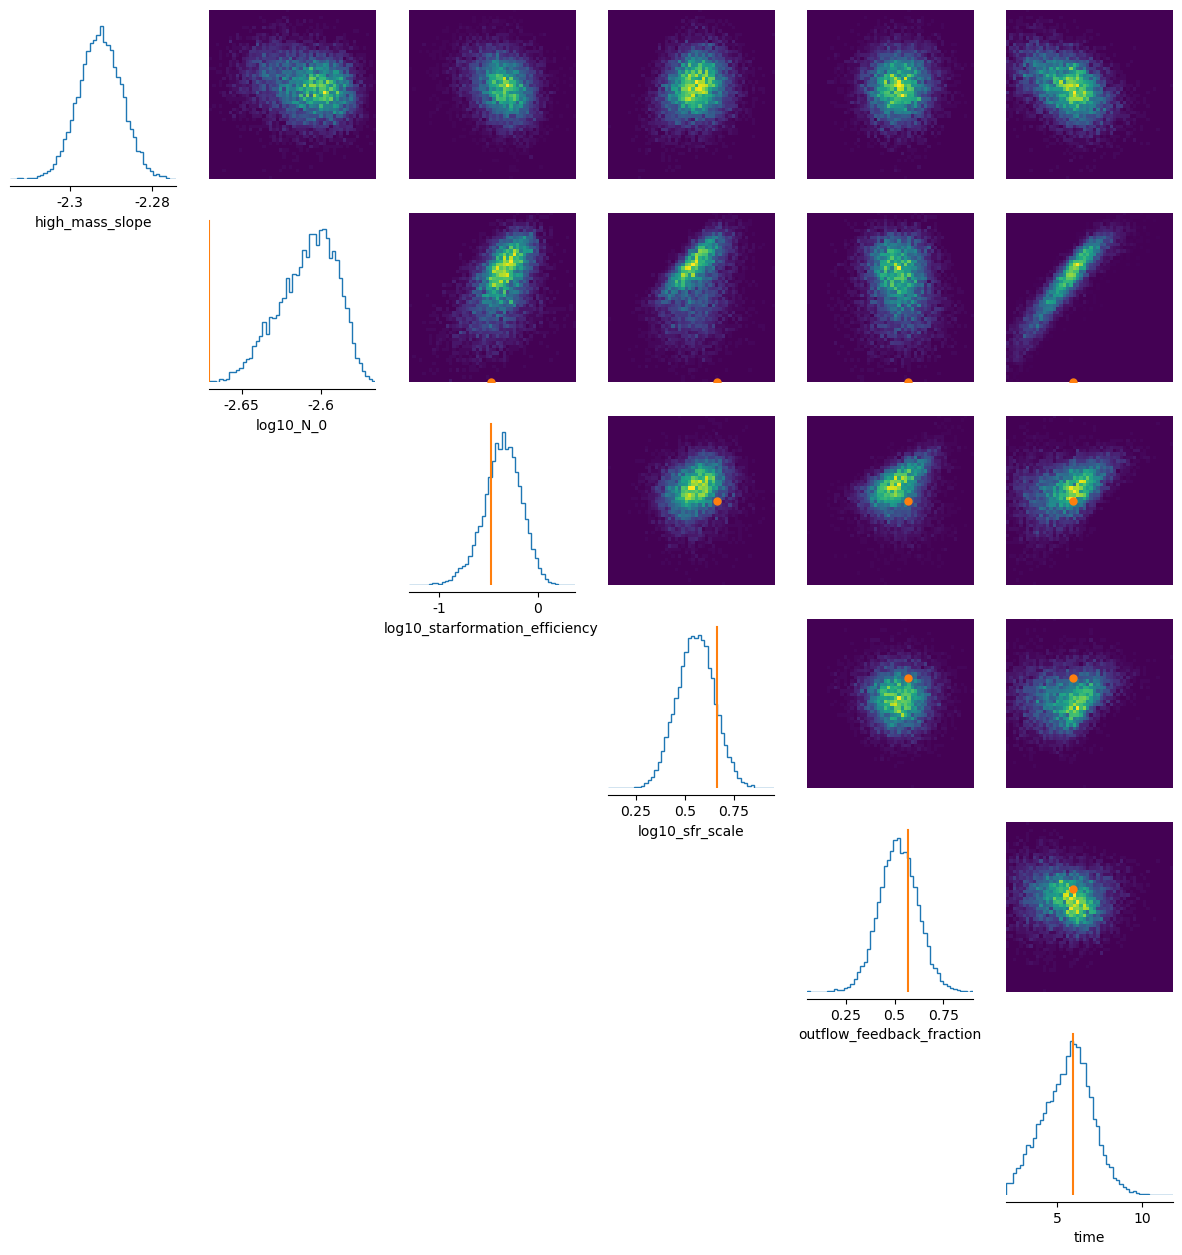

In [16]:
posterior_samples = posterior.sample((10000,), x=simulated_data)
print(prior)
_ = pairplot(posterior_samples, figsize=(15, 15), points=prior, labels=labels)

Drawing 10000 posterior samples: 10187it [00:15, 640.84it/s]                          


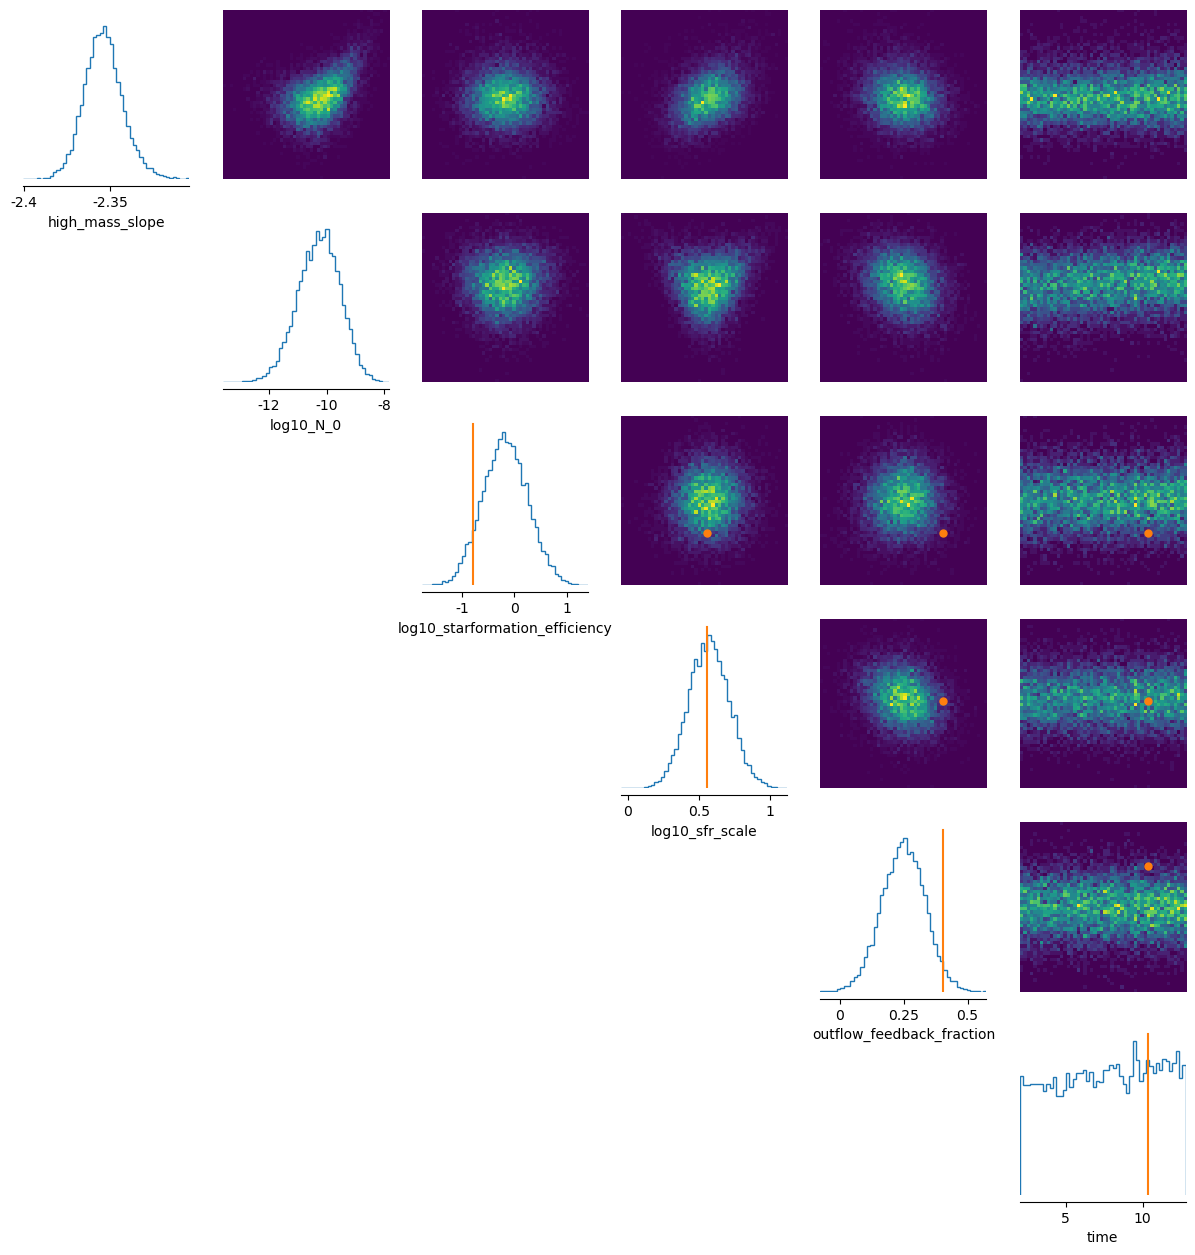

In [17]:
index = 100
x = val_x[index][:-1]*x_std + x_mean
y = val_y[index]

posterior_samples = posterior.sample((10000,), x=y)
_ = pairplot(posterior_samples, figsize=(15, 15), points=x, labels=labels)


In [19]:
a.p0

array([-2.3 , -2.75, -0.3 ,  0.55,  0.5 ])